# Comparison of NSF and PRISMO on SlideSeq Mous Brain Data

In [14]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import mofax as mofa
from prismo import PRISMO
from prismo.tl import match
from plotnine import *
from data_loader import load_nsf_slideseq
import os
import h5py
import pickle as pkl

from prismo.pl import plot_training_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
data = load_nsf_slideseq()

In [65]:
z_nsf, w_nsf = pkl.load(open(f"lvs/nsf.pkl", "rb")).values()

z_nsf = pd.DataFrame(
    z_nsf,
    columns=[f"Factor {i}" for i in range(z_nsf.shape[1])],
    index=data.obs_names
)

w_nsf_dict = {}
w_nsf_dict["mRNA"] = pd.DataFrame(
    w_nsf,
    columns=[f"Factor {i+1}" for i in range(w_nsf.shape[1])],
    index=data.var_names
)
w_nsf = w_nsf_dict

z_prismo = {}
w_prismo = {}
prismo_model = {}
for seed in range(10):
    prismo_model[seed] = PRISMO.load(f"models/prismo_{seed}.h5")
    z_prismo[seed] = prismo_model[seed].get_factors()['group_1']
    w_prismo[seed] = {}
    w_prismo[seed]["mRNA"] = prismo_model[seed].get_weights()["view_1"].T

### Factor matching based on correlation

In [66]:
for seed in range(10):
    z_nsf_inds, z_prismo_inds, z_signs = match(z_nsf, z_prismo[seed], dim=-1)

    z_prismo[seed] = z_prismo[seed].iloc[:, z_prismo_inds]
    z_prismo[seed] = z_prismo[seed] * z_signs.reshape(1, -1)
    z_prismo[seed].columns = [f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])]

    for view in w_prismo[seed].keys():
        w_prismo[seed][view] = w_prismo[seed][view].iloc[:, z_prismo_inds]
        w_prismo[seed][view] = w_prismo[seed][view] * z_signs.reshape(1, -1)
        w_prismo[seed][view].columns = [f"Factor {i+1}" for i in range(w_prismo[seed][view].shape[1])]

### Reordering factors to have high correlation first

In [87]:
n_factors = z_prismo[0].shape[1]

df = []
for seed in range(10):
    corr = []
    for i in range(n_factors):
        corr.append(pearsonr(w_prismo[seed][view].iloc[:, i], w_nsf[view].iloc[:, i])[0].item())
    df.append(pd.DataFrame(corr, columns=[f"corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
    df[-1]["lv"] = f"Weights ({view})"

df = pd.concat(df, axis=0)
new_order = df.groupby("factor", observed=True)["corr"].mean().sort_values(ascending=False).index.astype(int) - 1

w_nsf["mRNA"] = w_nsf["mRNA"].iloc[:, new_order]
w_nsf["mRNA"].columns = [f"Factor {i+1}" for i in range(w_nsf["mRNA"].shape[1])]
z_nsf = z_nsf.iloc[:, new_order]
z_nsf.columns = [f"Factor {i+1}" for i in range(z_nsf.shape[1])]
for seed in range(10):
    w_prismo[seed]["mRNA"] = w_prismo[seed]["mRNA"].iloc[:, new_order]
    w_prismo[seed]["mRNA"].columns = [f"Factor {i+1}" for i in range(w_prismo[seed]["mRNA"].shape[1])]
    z_prismo[seed] = z_prismo[seed].iloc[:, new_order]
    z_prismo[seed].columns = [f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])]

### Correlation plots

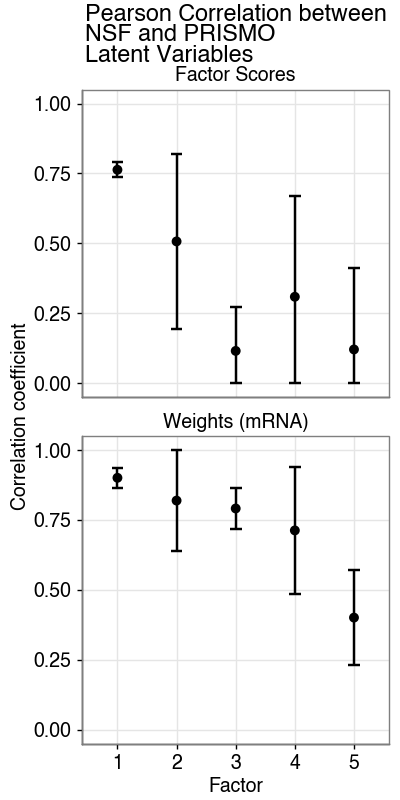

In [88]:
seeds = list(z_prismo.keys())
views = list(w_prismo[seeds[0]].keys())
n_factors = z_prismo[0].shape[1]

df = []
for seed in seeds:
    corr = []
    for i in range(n_factors):
        corr.append(pearsonr(z_prismo[seed].iloc[:, i], z_nsf.iloc[:, i])[0])
    df.append(pd.DataFrame(corr, columns=["corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
    df[-1]["lv"] = "Factor Scores"

    for view in views:
        corr = []
        for i in range(n_factors):
            corr.append(pearsonr(w_prismo[seed][view].iloc[:, i], w_nsf[view].iloc[:, i])[0].item())
        df.append(pd.DataFrame(corr, columns=[f"corr"]))
        df[-1]["seed"] = seed
        df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
        df[-1]["lv"] = f"Weights ({view})"

df = pd.concat(df, axis=0)

df = df.groupby(["factor", "lv"])["corr"].aggregate(["mean", "std"]).reset_index()
df["min"] = df["mean"] - df["std"]
df["max"] = df["mean"] + df["std"]
df["factor"] = pd.Categorical(df["factor"], categories=[f"{i+1}" for i in range(n_factors)], ordered=True)
df["min"] = np.clip(df["min"], a_min=0., a_max=1.)
df["max"] = np.clip(df["max"], a_min=0., a_max=1.)

plot = (
    ggplot(df, aes(x="factor", y="mean", group="lv"))
    + geom_point(size=1.)
    + geom_errorbar(aes(ymin="min", ymax="max"), width=0.2)
    + facet_wrap("~lv", scales="fixed", ncol=1)
    + theme(
        figure_size=(2, 4),
        panel_spacing_y=0.05
    )
    + labs(x="Factor", y="Correlation coefficient", title="Pearson Correlation between\nNSF and PRISMO\nLatent Variables")
    + ylim(0, 1)
)

fig = plot.draw()
fig.savefig("plots/correlations.pdf")
plot.show()

### Weights scatter plots

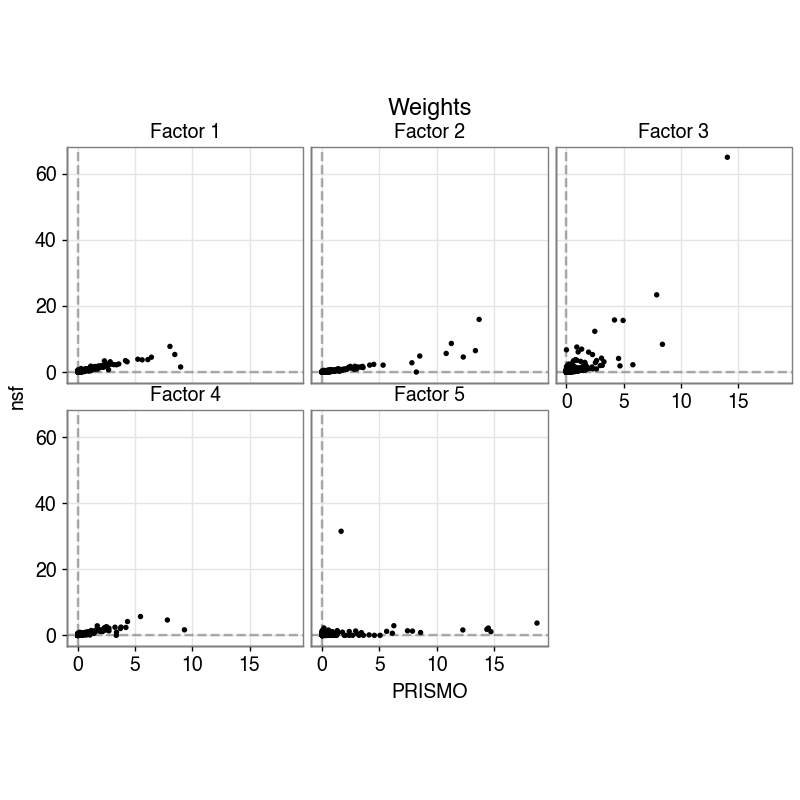

In [89]:
factors = ["Factor 1", "Factor 2", "Factor 3", "Factor 4", "Factor 5"]
seed = 1

df_list = []
for factor in factors:
    df = pd.DataFrame(w_prismo[seed][view][factor])
    df.columns = ["weight_prismo"]
    df["weight_nsf"] = w_nsf[view][factor]
    df["weight_prismo_abs"] = df["weight_prismo"].abs()
    df["weight_nsf_abs"] = df["weight_nsf"].abs()
    df["factor"] = factor
    df_list.append(df)

# Concatenate all the DataFrames
df_all = pd.concat(df_list, ignore_index=True)

plot = (
    ggplot(df_all, aes(x="weight_prismo", y="weight_nsf"))
    + geom_point(size=.1)
    + labs(x="PRISMO", y="nsf", title="Weights")
    + theme(figure_size=(4, 4))
    + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
    + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    + facet_wrap("~factor", scales="fixed")
)

fig = plot.draw()
fig.savefig("plots/weights.pdf")
plot.show()

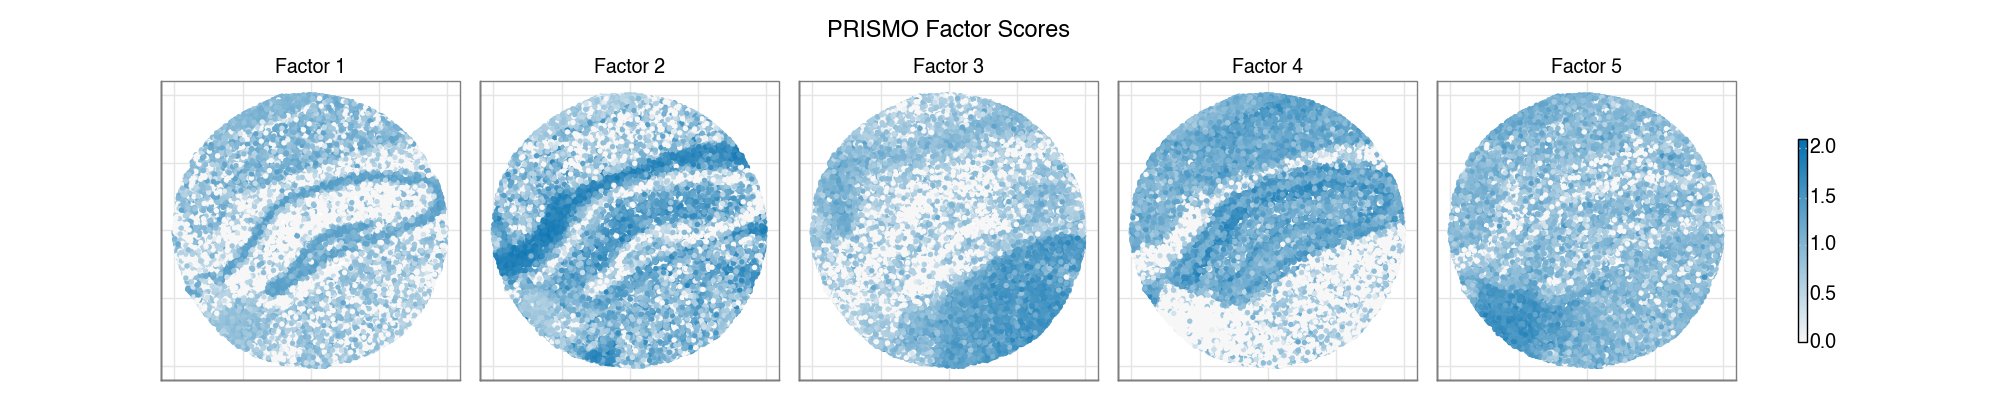

In [90]:
seed = 0

covariates_df = pd.DataFrame(prismo_model[seed].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_prismo[seed], columns=[f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]
df_long = df.melt(id_vars=["x", "y"], value_vars=[f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])], var_name="Factor", value_name="Score")
df_long["Score"] = np.sqrt(df_long["Score"])

plot = (
    ggplot(df_long, aes(x="x", y="y", color="Score"))
    + geom_point(size=0.1)
    + theme(
        figure_size=(2 * z_prismo[seed].shape[1], 2),
        axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_ticks_major_y=element_blank(),
        legend_key_width=3.,
    )
    + labs(x="", y="", color="", title="PRISMO Factor Scores")
    + coord_fixed(ratio=1)
    + scale_color_gradient(low="#f7f7f7", high="#0571b0")
    + facet_wrap("~Factor", nrow=1)
)

fig = plot.draw()
fig.savefig("plots/prismo_factors.pdf")
plot.show()

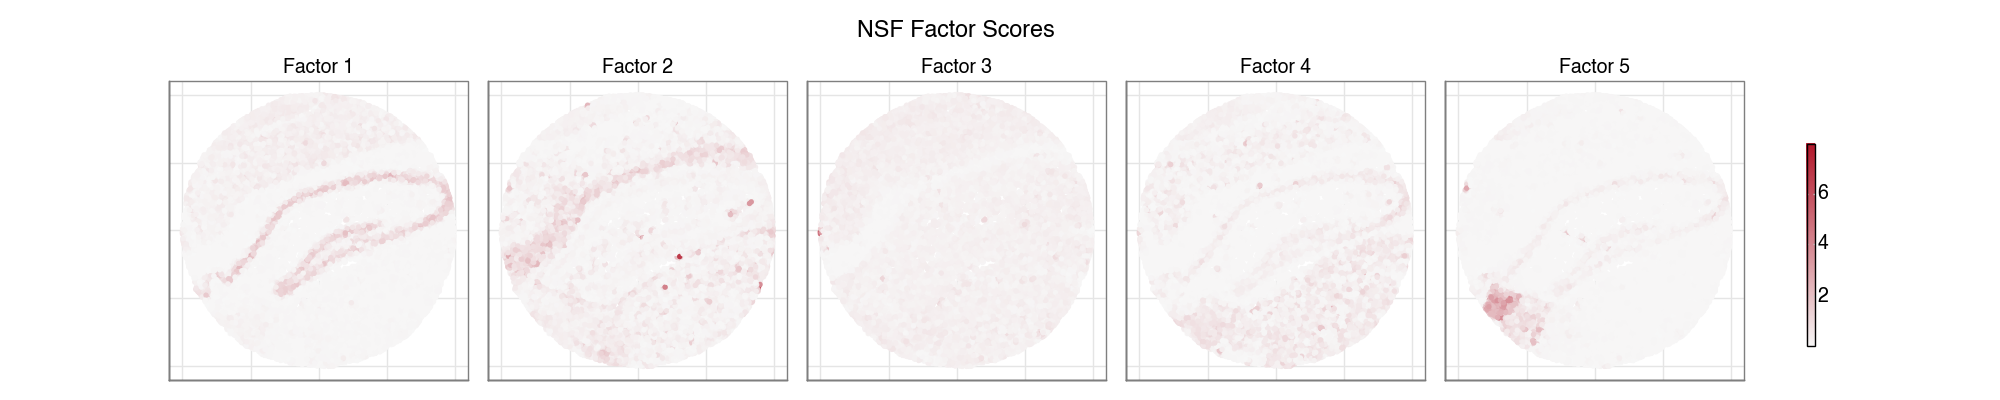

In [92]:
covariates_df = pd.DataFrame(prismo_model[1].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_nsf.values, columns=[f"Factor {i+1}" for i in range(z_nsf.shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]
df_long = df.melt(id_vars=["x", "y"], value_vars=[f"Factor {i+1}" for i in range(z_nsf.shape[1])], var_name="Factor", value_name="Score")

plot = (
    ggplot(df_long, aes(x="x", y="y", color="Score"))
    + geom_point(size=0.1)
    + theme(
        figure_size=(2 * z_nsf.shape[1], 2),
        axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_ticks_major_y=element_blank(),
        legend_key_width=3.,
    )
    + labs(x="", y="", color="", title="NSF Factor Scores")
    + coord_fixed(ratio=1)
    + scale_color_gradient(low="#f7f7f7", high="#B2182B")
    + facet_wrap("~Factor", nrow=1)
)

fig = plot.draw()
fig.savefig("plots/nsf_factors.pdf")
plot.show()